## RPA and pRPA imaging
### Figure S2

In [2]:
library(ggplot2)
library(patchwork)
library(dplyr)
library(ggrastr)

In [4]:
# get first mode 
get_mode = function(num_list, m="g1") {
    # d <- density(subset(data, ImageNumber == 1)$Intensity_IntegratedIntensity_OrigBlue)
    d = density(num_list)
    modes <- function(d){
        i <- which(diff(sign(diff(d$y))) < 0) + 1
        data.frame(x = d$x[i], y = d$y[i])
    }

    df = subset(modes(d), x>200 & y > 0.0005)  # needs to be higher than a certain amount and also have at least 0.0005 density [empirically found]

    if (m == "g1") return(df$x[1])  # first mode for G1
    if (m == "g2") return(df$x[length(df$x)])  # last mode for G2 

    #return(d$x[which.max(d$y)])    # get the top mode
    
}


## Process single conditions

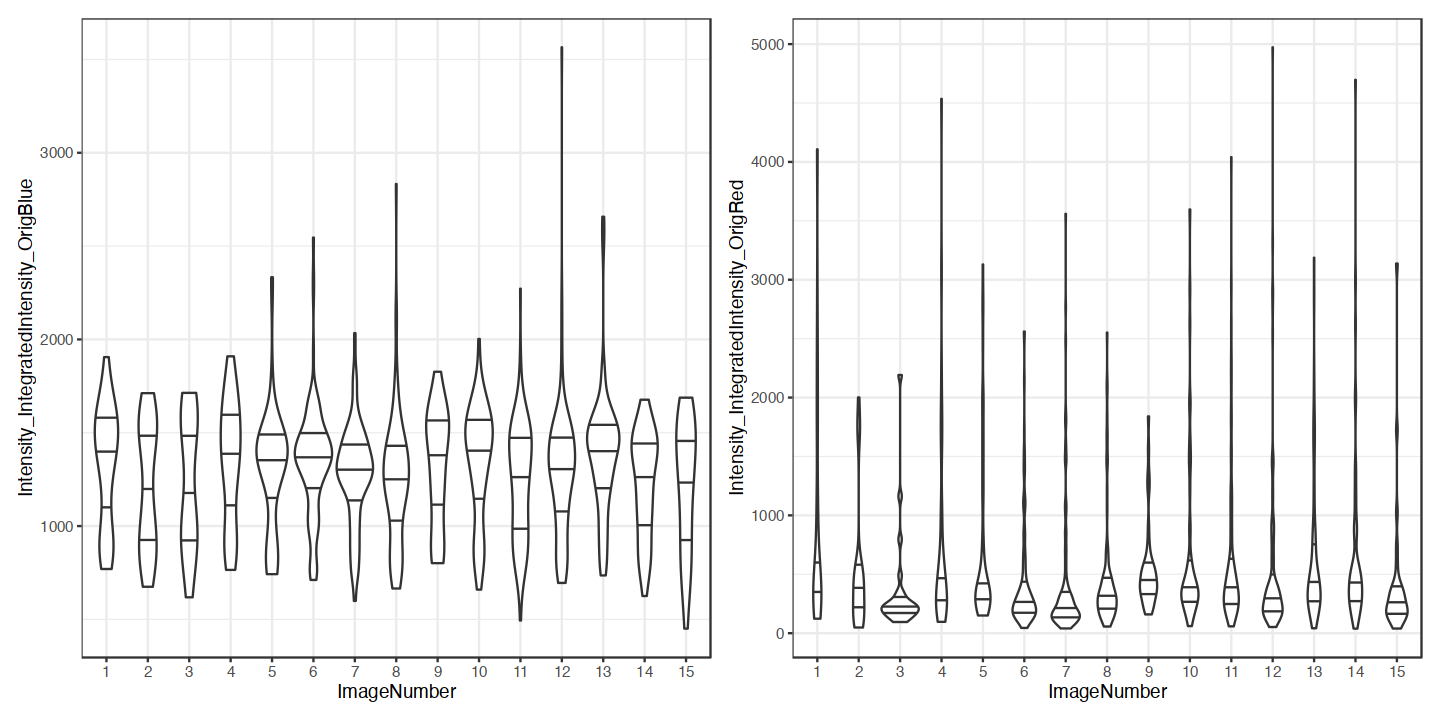

In [624]:
#data = read.csv("Slide M2 - B1 24h RPA/region56.csv", header=1)
#data = read.csv("~/Documents/Images/BD432/230901_BD432_8h_pRPA//region04.csv", header=1)
data = read.csv("../data/BD432/230907_BD432_24h_pRPAS48_pRPAS33_images/Slide M2 - A3/region21.csv", header=1)
data$ImageNumber = factor(data$ImageNumber)

options(repr.plot.width=12, repr.plot.height=6)
g1 = ggplot(data, aes(x=ImageNumber, y=Intensity_IntegratedIntensity_OrigBlue)) +
geom_violin(draw_quantiles = c(.25,.5,.75)) + theme_bw()
g2 = ggplot(data, aes(x=ImageNumber, y=Intensity_IntegratedIntensity_OrigRed)) +
geom_violin(draw_quantiles = c(.25,.5,.75)) + theme_bw()

g1 + g2

In [759]:
data

ImageNumber ObjectNumber AreaShape_Area
1    1            1            6148         
2    1            2            7598         
3    1            3            9315         
4    1            4           10602         
5    1            5           10058         
6    1            6            8927         
7    1            7           10612         
8    1            8            8322         
9    1            9           11083         
10   1           10           10353         
11   1           11            6057         
12   1           12           13113         
13   1           13            6986         
14   1           14            7919         
15   1           15            9984         
16   1           16           12935         
17   1           17            7186         
18   1           18           10766         
19   1           19            9244         
20   1           20            9004         
21   1           21           11975         
22   1           22            9231         
23   1           23           10849         
24   1           24           13174         
25   1           25           11736         
26   1           26            7106         
27   1           27            9105         
28   1           28           10704         
29   1           29            8885         
30   1           30            9027         
⋮    ⋮           ⋮            ⋮             
1077 15           2            8298         
1078 15           3           11131         
1079 15           4           11282         
1080 15           5            9896         
1081 15           6            9960         
1082 15           7            6289         
1083 15           8            6112         
1084 15           9           10542         
1085 15          10            6524         
1086 15          11            6690         
1087 15          12           11247         
1088 15          13            7398         
1089 15          14            8717         
1090 15          15           12342         
1091 15          16           10759         
1092 15          17            9083         
1093 15          18            9411         
1094 15          19           11682         
1095 15          20           11838         
1096 15          21           12967         
1097 15          22            8571         
1098 15          23           11108         
1099 15          24            9825         
1100 15          25           11703         
1101 15          26           12418         
1102 15          27            7269         
1103 15          28            8914         
1104 15          29           11147         
1105 15          30            8003         
1106 15          31           12113         
     Intensity_IntegratedIntensity_OrigBlue
1     836.7922                             
2     961.4196                             
3    1506.3569                             
4    1557.6902                             
5    1427.1020                             
6    1452.4118                             
7    1343.4549                             
8     884.6549                             
9    1482.8040                             
10   1495.2746                             
11    910.3961                             
12   1905.2746                             
13    921.1334                             
14   1218.2432                             
15   1249.6353                             
16   1854.0079                             
17    859.8079                             
18   1515.1412                             
19   1534.2628                             
20   1390.1530                             
21   1635.6275                             
22   1592.4589                             
23   1602.5334                             
24   1648.2079                             
25   1798.7726                             
26   1393.5608                             
27   1316.6432             

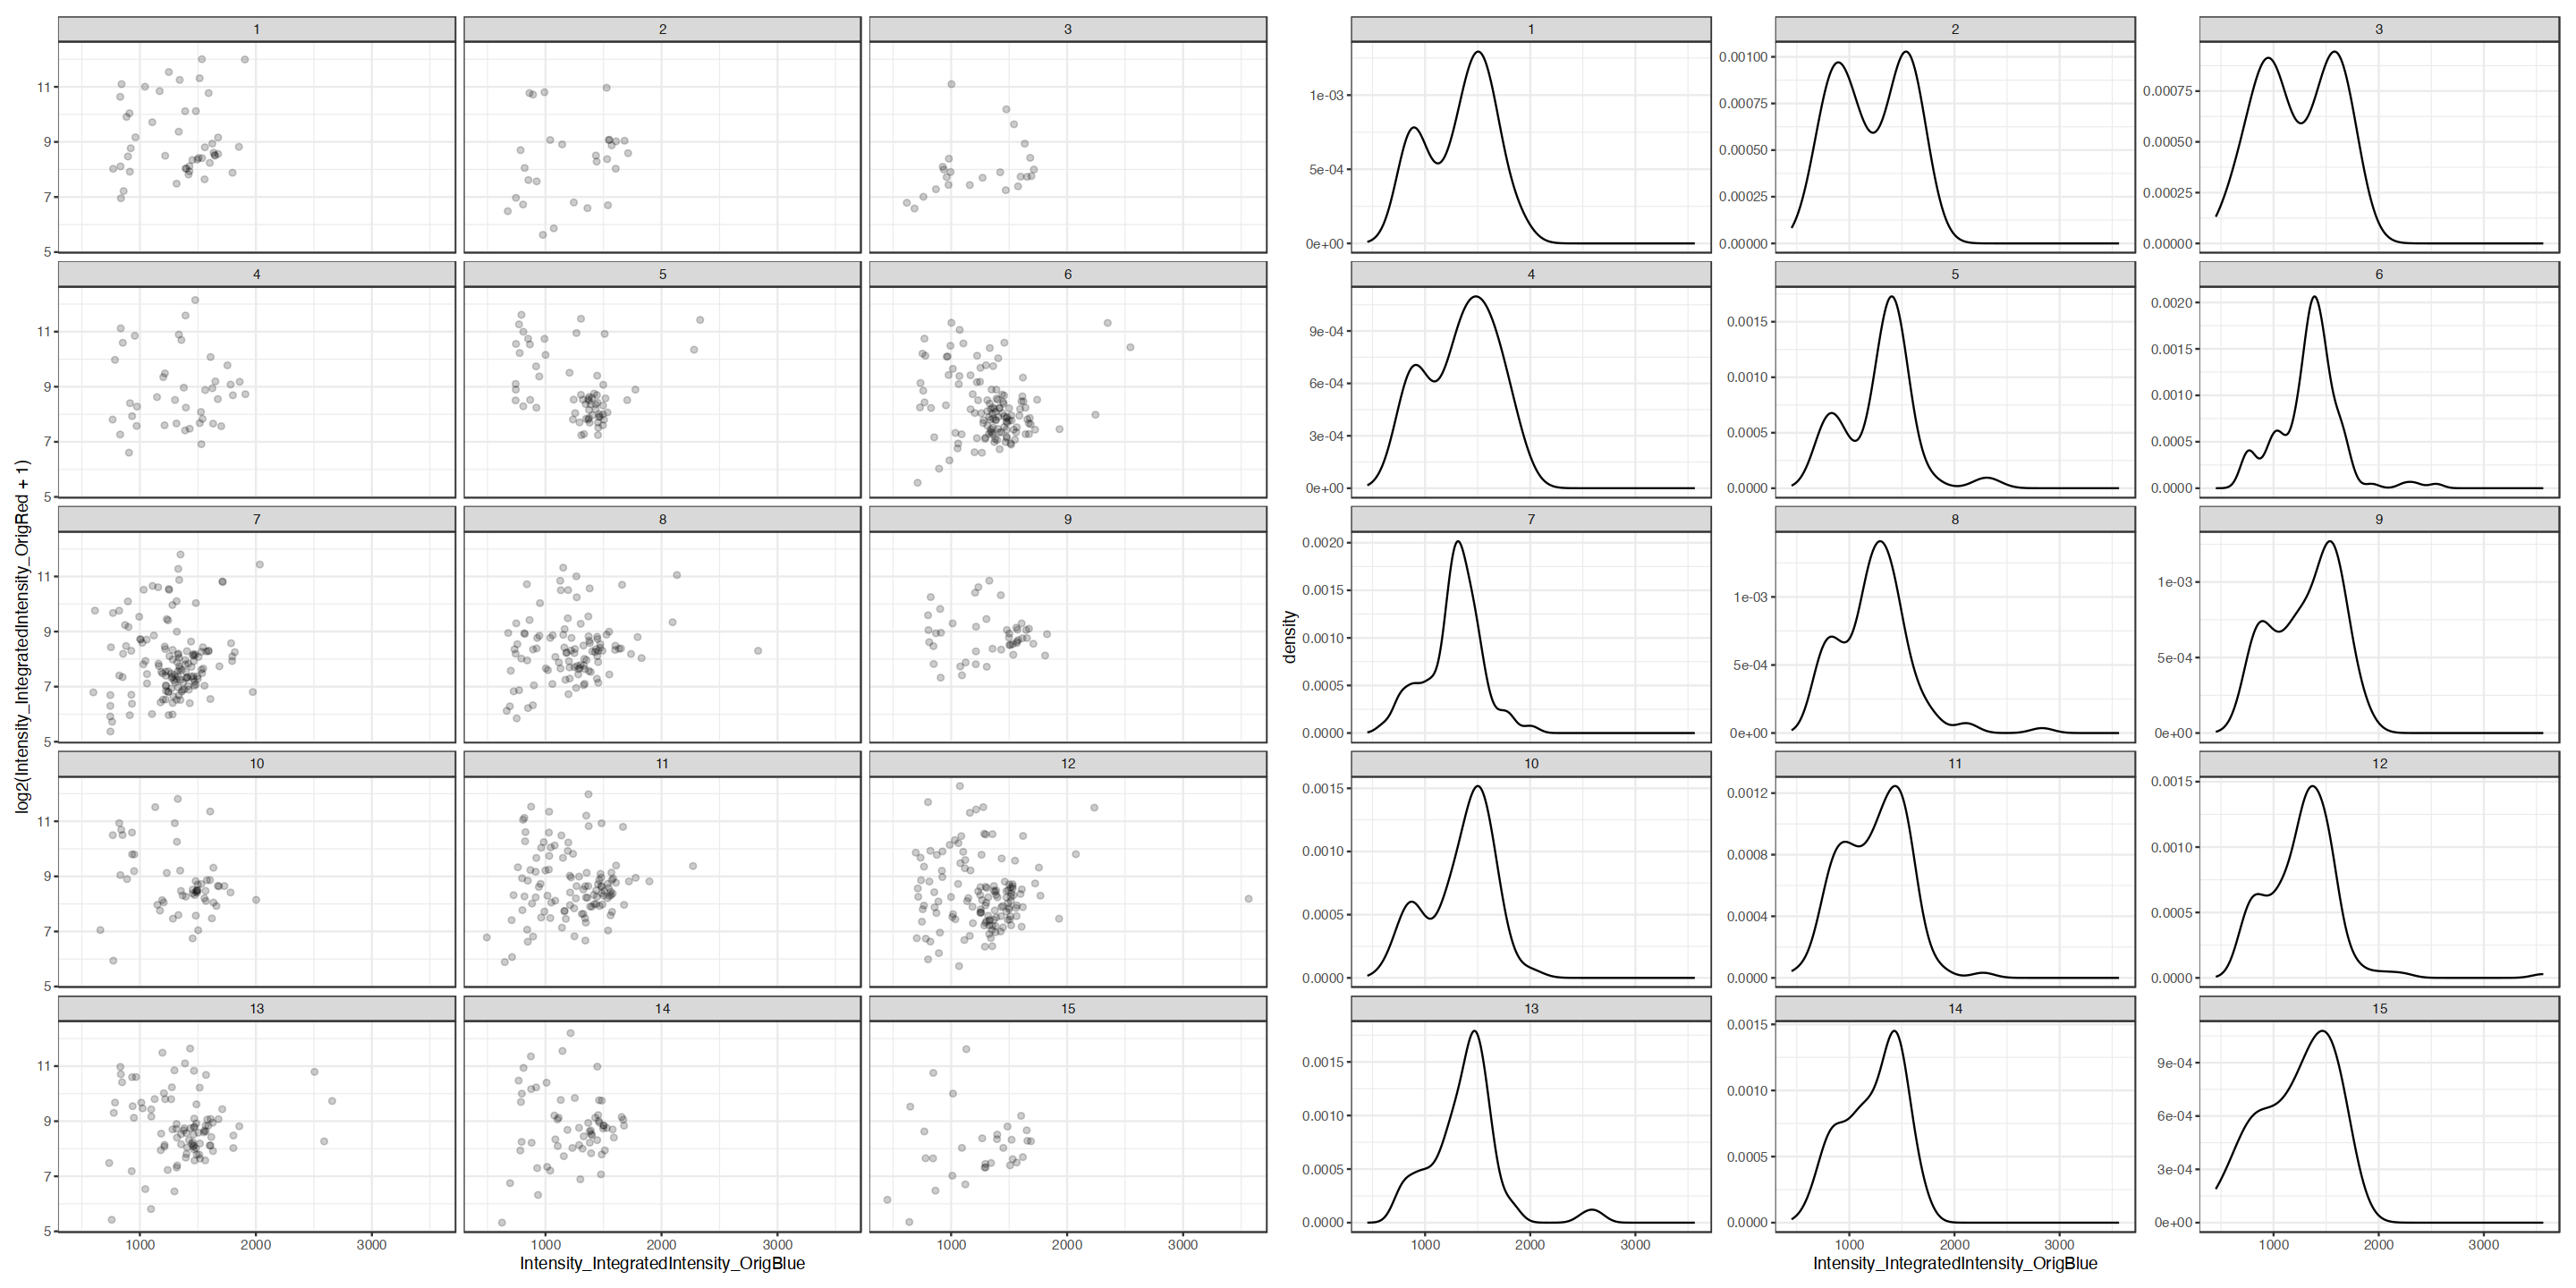

In [625]:
# raw data
options(repr.plot.width=24, repr.plot.height=12)

g1 = ggplot(data, aes(x=Intensity_IntegratedIntensity_OrigBlue, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_point(alpha=0.2) + facet_wrap(facets=c("ImageNumber"), ncol=3) + theme_bw()

g2 = ggplot(data, aes(x=Intensity_IntegratedIntensity_OrigBlue)) + 
geom_density() + facet_wrap(facets=c("ImageNumber"), ncol=3, scales = "free_y") + theme_bw()

g1 + g2

In [639]:
# remove ones with median < 400
# too low --> maybe a bubble or something d
stats_by_img = data %>% group_by(ImageNumber) %>% summarize(med = median(Intensity_IntegratedIntensity_OrigBlue),
                                                            count = n())
remove = subset(stats_by_img, med < 400 | count < 10)$ImageNumber
data_new = subset(data, !(ImageNumber %in% remove))

stats_new = data_new %>% group_by(ImageNumber) %>% summarize(g1 = get_mode(Intensity_IntegratedIntensity_OrigBlue, m="g1"))
data_new$dapi_norm = apply(data_new, 1, function(x) 
    as.numeric(x["Intensity_IntegratedIntensity_OrigBlue"])/
    stats_new[stats_new$ImageNumber == as.numeric(x["ImageNumber"]),]$g1)
                                                                
# normalize
data_new$dapi_norm = apply(data_new, 1, function(x) 
    as.numeric(x["Intensity_IntegratedIntensity_OrigBlue"])/
    stats_new[stats_new$ImageNumber == as.numeric(x["ImageNumber"]),]$g1)
head(data_new)

ImageNumber ObjectNumber AreaShape_Area
1 1           1             6148         
2 1           2             7598         
3 1           3             9315         
4 1           4            10602         
5 1           5            10058         
6 1           6             8927         
  Intensity_IntegratedIntensity_OrigBlue Intensity_IntegratedIntensity_OrigRed
1  836.7922                              123.0235                             
2  961.4196                              573.9020                             
3 1506.3569                              341.0431                             
4 1557.6902                              198.7216                             
5 1427.1020                              276.7569                             
6 1452.4118                              323.6196                             
  Intensity_MeanIntensity_OrigBlue Intensity_MeanIntensity_OrigRed dapi_norm
1 0.1361080                        0.02001033                      0.9356198
2 0.1265359                        0.07553330                      1.0749661
3 0.1617130                        0.03661225                      1.6842620
4 0.1469242                        0.01874378                      1.7416580
5 0.1418873                        0.02751609                      1.5956469
6 0.1626988                        0.03625178                      1.6239459

[1] 1105    8

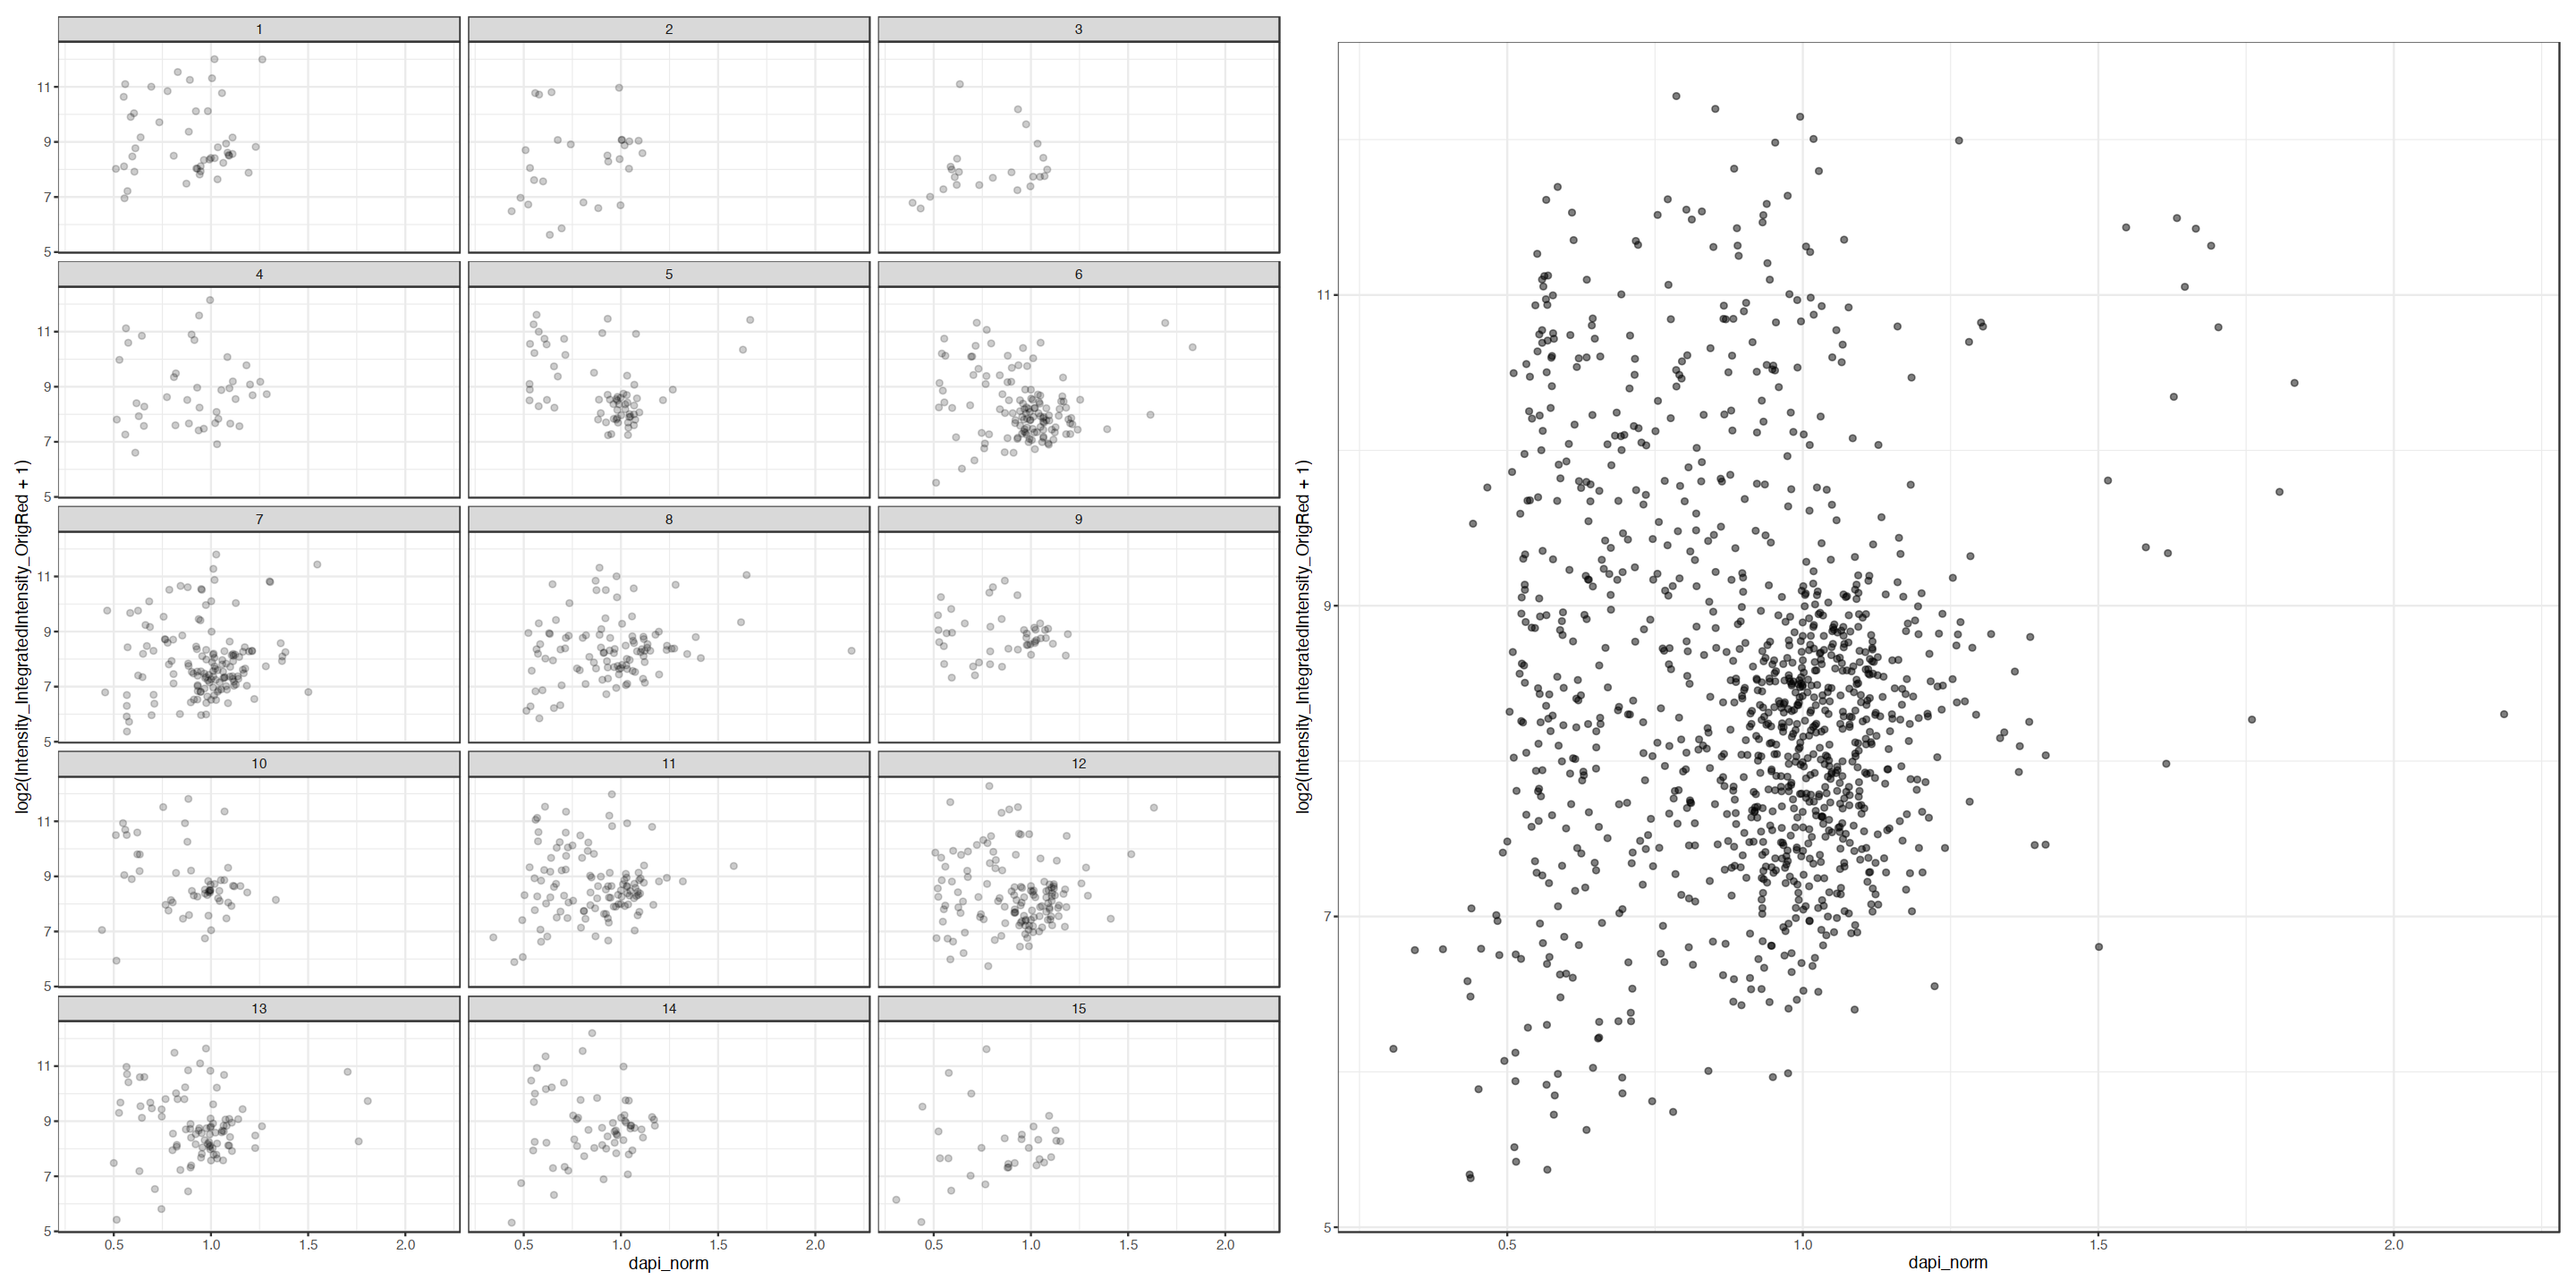

In [638]:
options(repr.plot.width=24, repr.plot.height=12)

#dim(data_new)
data_new = subset(data_new, dapi_norm < 2.5)
dim(data_new)

g1 = ggplot(data_new, aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_point(alpha=0.2) + facet_wrap(facets=c("ImageNumber"), ncol=3) + theme_bw()

g2 = ggplot(data_new, aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_point(alpha=0.5) + theme_bw()

g1 + g2

## Combining reps for each condition

In [6]:
get_data = function(dir, reg, tx, g2=FALSE) {
    data = read.csv(paste(dir, reg, ".csv", sep=''), header=1)
    data$ImageNumber = factor(data$ImageNumber)
    
    stats_by_img = data %>% group_by(ImageNumber) %>% summarize(med = median(Intensity_IntegratedIntensity_OrigBlue),
                                                                count = n())
    remove = subset(stats_by_img, med < 400 | count < 10)$ImageNumber  # get rid of images with fewer than 10 cells, or a DAPI median of less than 400 
    data_new = subset(data, !(ImageNumber %in% remove))
    
    if (g2) {  # use when we want to align cells by the second mode (i.e. for HU 500 µM 24h)
        stats_new = data_new %>% group_by(ImageNumber) %>% summarize(g2 = get_mode(Intensity_IntegratedIntensity_OrigBlue, m = "g2"))
        data_new$dapi_norm = apply(data_new, 1, function(x) 
            as.numeric(x["Intensity_IntegratedIntensity_OrigBlue"])/
            stats_new[stats_new$ImageNumber == as.numeric(x["ImageNumber"]),]$g2 * 2)
    } else {  # in all other cases, align by the first mode 
        stats_new = data_new %>% group_by(ImageNumber) %>% summarize(g1 = get_mode(Intensity_IntegratedIntensity_OrigBlue, m = "g1"))
        data_new$dapi_norm = apply(data_new, 1, function(x) 
            as.numeric(x["Intensity_IntegratedIntensity_OrigBlue"])/
            stats_new[stats_new$ImageNumber == as.numeric(x["ImageNumber"]),]$g1)        
    }
    
    data_new = subset(data_new, dapi_norm < 2.5)
    data_new = subset(data_new, dapi_norm > 0.5)

    data_new$region = reg
    data_new$tx = tx
    return(data_new)
}

plot_data = function(df, title, drawline = F, m=0, b=0) {    
    
    # if we want to plot MEAN intensity, could use
    # ggplot(df, aes(x=dapi_norm, y=log2(Intensity_MeanIntensity_OrigRed*10000+1))) 
    # but this doesn't represent total signals
    
    print(dim(df))
    g1 = ggplot(df, aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
    geom_point(alpha=0.05, size=0.1) + facet_wrap(facets=c("tx", "region"), nrow=3, dir="v") + theme_bw() + 
    coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + xlab("Normalized DAPI") + ylab("log2 signal")
    
    if (drawline) g1 = g1 + geom_abline(slope=m, intercept=b)

    g2 = ggplot(df, aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
    geom_point(alpha=0.01, size=0.3) + facet_wrap(facets=c("tx"), ncol=5) + theme_bw() + 
    coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + ggtitle(title) + xlab("Normalized DAPI") + ylab("log2 signal")

    g3 = ggplot(df, aes(x=tx, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
    geom_violin(draw_quantiles = c(.25,.5,.75)) + ggtitle(title) + theme_bw() + xlab("Normalized DAPI") + ylab("log2 signal")

    options(repr.plot.width=16, repr.plot.height=8)
    layout <- "
    AAABB
    AAACC
    AAACC
    "
    g1 + g2 + g3 + plot_layout(design=layout)
}

[1] 23951    10


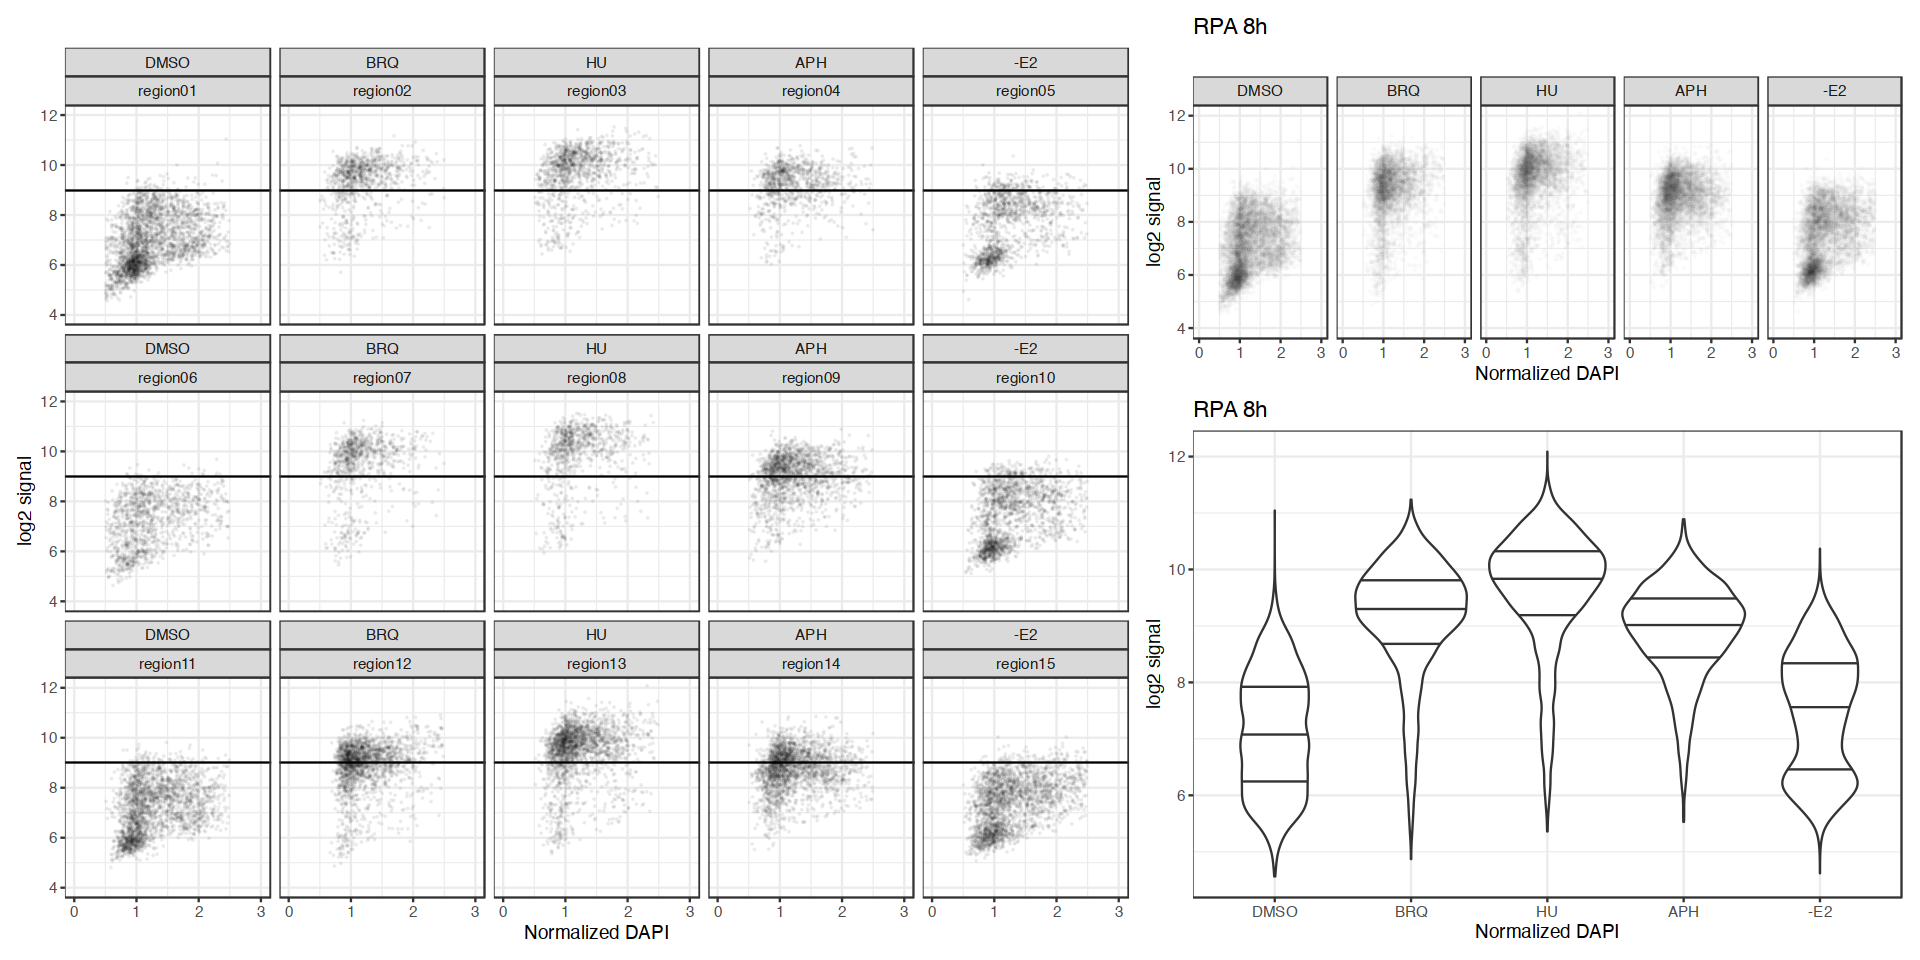

In [7]:
# 8h RPA
#dir = "~/Documents/Images/BD432/230830_bd432_8h_rpa/"
dir = "../data/bd432_data/230830_bd432_8h_rpa/"
dmso = do.call(rbind, lapply(c("region01", "region06", "region11"), function(x) get_data(dir, x, "DMSO")))
brq = do.call(rbind, lapply(c("region02", "region07", "region12"), function(x) get_data(dir, x, "BRQ")))
hu = do.call(rbind, lapply(c("region03", "region08", "region13"), function(x) get_data(dir, x, "HU")))
aph = do.call(rbind, lapply(c("region04", "region09", "region14"), function(x) get_data(dir, x, "APH")))
e2wd = do.call(rbind, lapply(c("region05", "region10", "region15"), function(x) get_data(dir, x, "-E2")))
                           
all_data_8h = rbind(dmso, brq, hu, aph, e2wd)
all_data_8h$tx = factor(all_data_8h$tx, levels=c("DMSO", "BRQ", "HU", "APH", "-E2"))
plot_data(all_data_8h, "RPA 8h", drawline=T, m=0, b=9)
#ggsave("230910_bd432_rpa8h.pdf", width=8, height=6)

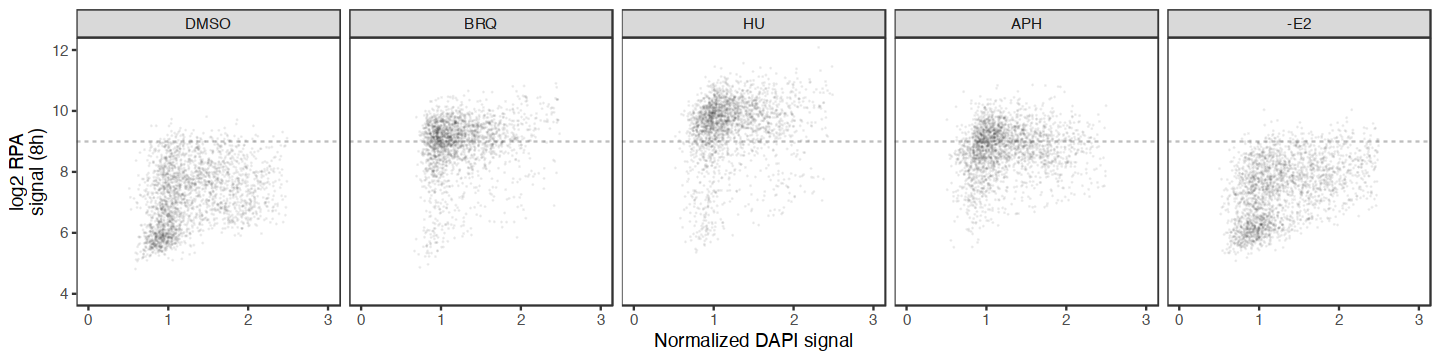

In [8]:
options(repr.plot.width=12, repr.plot.height=3)
g1 = ggplot(subset(all_data_8h, region %in% c("region11", "region12", "region13", "region14", "region15")),
            aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_hline(yintercept=9, color="gray", linetype=2) + 
rasterise(geom_point(alpha=0.05, size=0.01), dpi=300) + facet_wrap(facets=c("tx"), nrow=1) + theme_bw() + 
coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + xlab("Normalized DAPI signal") + ylab("log2 RPA\nsignal (8h)") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

g1

ggsave("../output/230912_bd432_8h_rpa.pdf", width=6, height=1.5)

In [9]:
# calculations
all_data_8h %>% group_by(region, tx) %>% summarize(pct = sum(Intensity_IntegratedIntensity_OrigRed>512)/n(),
                                                   mfi = median(Intensity_IntegratedIntensity_OrigRed))

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx   pct        mfi      
1  region01 DMSO 0.01813374  113.8039
2  region02 BRQ  0.74058127  765.1765
3  region03 HU   0.81552511  995.5177
4  region04 APH  0.68375136  635.3490
5  region05 -E2  0.10297483  233.5255
6  region06 DMSO 0.01757322  164.9647
7  region07 BRQ  0.78365385  906.9353
8  region08 HU   0.82958580 1202.8471
9  region09 APH  0.55507692  559.6981
10 region10 -E2  0.07807118  186.2726
11 region11 DMSO 0.02977989  149.3686
12 region12 BRQ  0.54484880  539.5412
13 region13 HU   0.77093359  818.3275
14 region14 APH  0.40695016  454.9216
15 region15 -E2  0.03859649  179.3902

[1] 36812    10


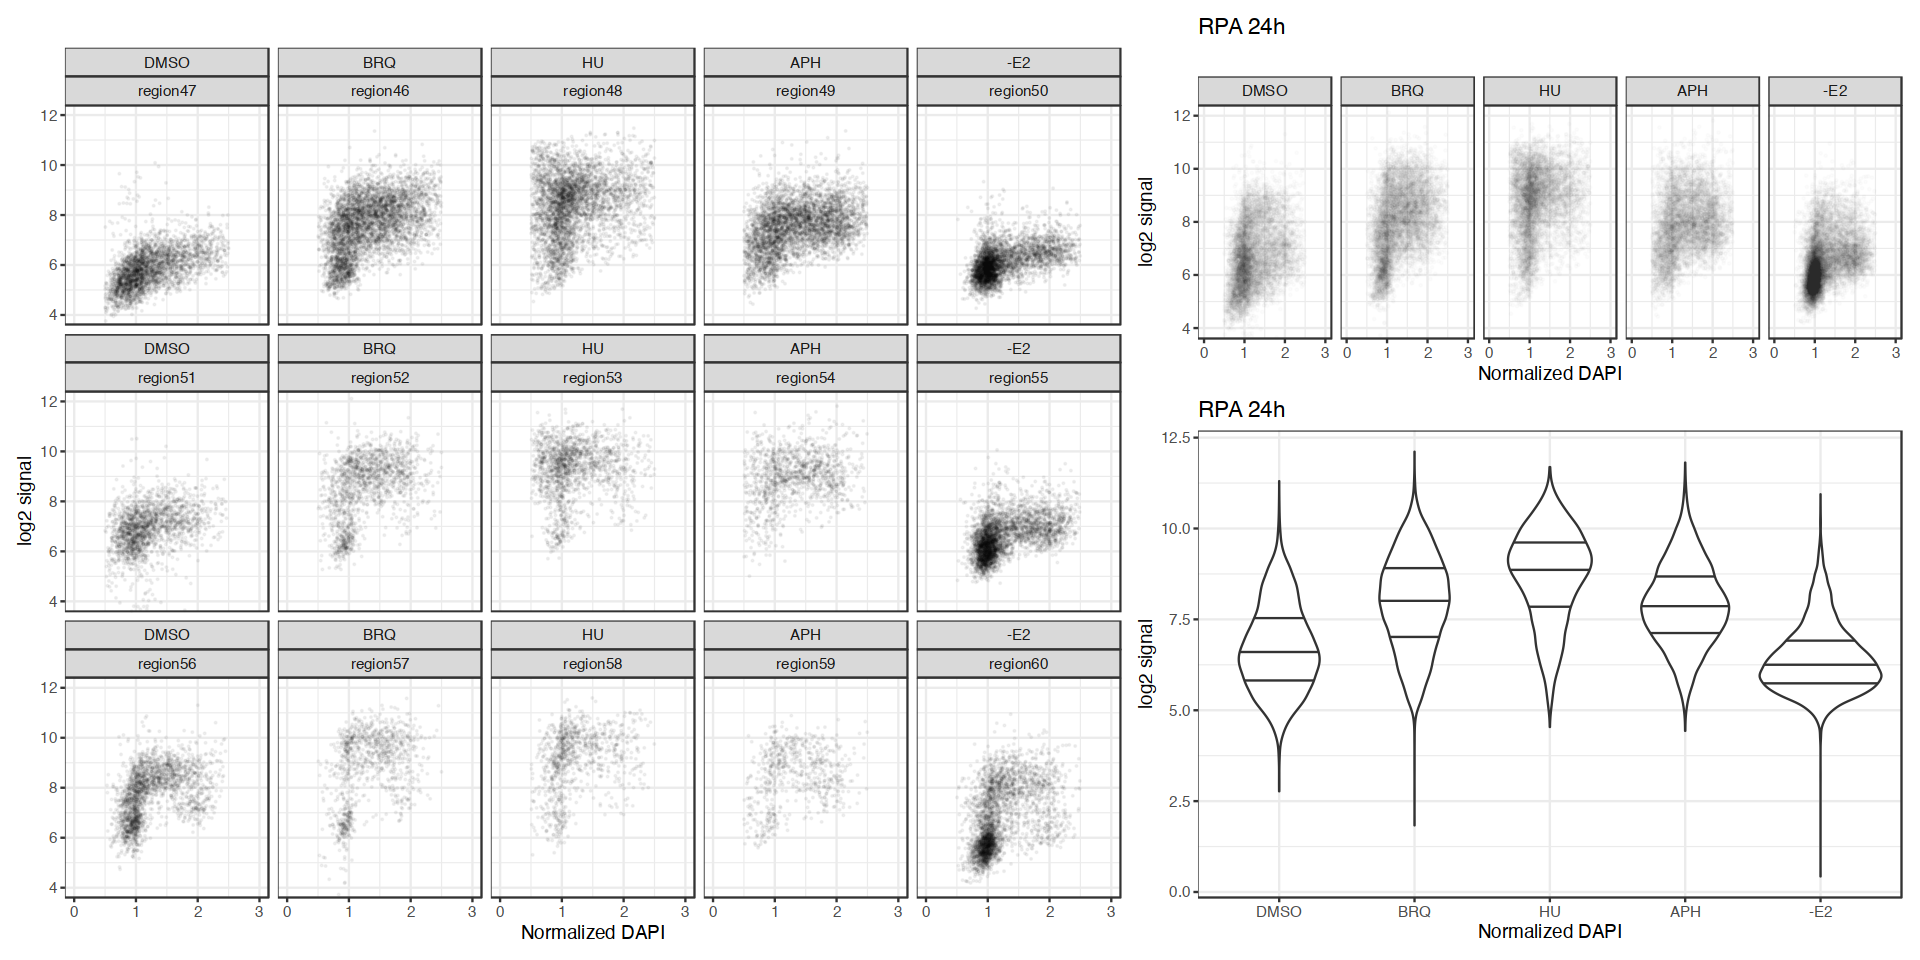

In [10]:
# 24h RPA
#dir = "~/Documents/Images/bd432/230830_BD432_8hPRPA_24hRPA/Images/Slide M2 - B1 24h RPA/"
dir = "../data/bd432_data/230901_bd432_24h_rpa/"
dmso = do.call(rbind, lapply(c("region47", "region51", "region56"), function(x) get_data(dir, x, "DMSO")))
brq = do.call(rbind, lapply(c("region46", "region52", "region57"), function(x) get_data(dir, x, "BRQ")))
hu = do.call(rbind, lapply(c("region48", "region53", "region58"), function(x) get_data(dir, x, "HU")))
aph = do.call(rbind, lapply(c("region49", "region54", "region59"), function(x) get_data(dir, x, "APH")))
e2wd = do.call(rbind, lapply(c("region50", "region55", "region60"), function(x) get_data(dir, x, "-E2")))
                           
all_data_24h = rbind(dmso, brq, hu, aph, e2wd)
all_data_24h$tx = factor(all_data_24h$tx, levels=c("DMSO", "BRQ", "HU", "APH", "-E2"))
plot_data(all_data_24h, "RPA 24h")
#ggsave("230910_bd432_rpa24h.pdf", width=8, height=6)

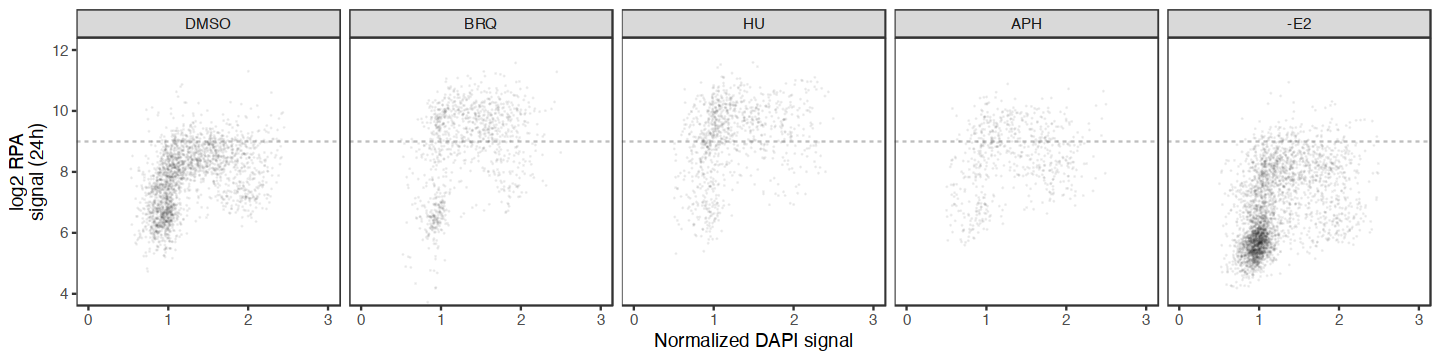

In [11]:
options(repr.plot.width=12, repr.plot.height=3)
g1 = ggplot(subset(all_data_24h, region %in% c("region56", "region57", "region58", "region59", "region60")),
            aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_hline(yintercept=9, color="gray", linetype=2) + 
rasterise(geom_point(alpha=0.05, size=0.01), dpi=300) + facet_wrap(facets=c("tx"), nrow=1) + theme_bw() + 
coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + xlab("Normalized DAPI signal") + ylab("log2 RPA\nsignal (24h)") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

g1

ggsave("../output/230912_bd432_24h_rpa.pdf", width=6, height=1.5)

In [12]:
all_data_24h %>% group_by(region, tx) %>% summarize(pct1 = sum(Intensity_IntegratedIntensity_OrigRed>128)/n(),  # rep 1
                                                    pct2 = sum(Intensity_IntegratedIntensity_OrigRed>256)/n(),  # rep 2
                                                    pct3 = sum(Intensity_IntegratedIntensity_OrigRed>512)/n(),  # rep 3
                                                    mfi = median(Intensity_IntegratedIntensity_OrigRed))  

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx   pct1       pct2        pct3         mfi      
1  region46 BRQ  0.71256533 0.385594183 0.0858895706 205.60393
2  region47 DMSO 0.06176569 0.010070493 0.0036925143  55.10588
3  region48 HU   0.83507853 0.649214660 0.3295811518 368.17452
4  region49 APH  0.72510348 0.294862430 0.0489408327 187.76863
5  region50 -E2  0.07694242 0.009052049 0.0007543374  64.89804
6  region51 DMSO 0.47268794 0.082747431 0.0070308275 124.31373
7  region52 BRQ  0.83600000 0.711333333 0.4346666667 450.20590
8  region53 HU   0.94307400 0.861480076 0.6710942441 687.17649
9  region54 APH  0.95564854 0.843514644 0.5079497908 517.11766
10 region55 -E2  0.24911900 0.036595283 0.0035239902  89.46275
11 region56 DMSO 0.73060649 0.449929478 0.0963798778 234.52550
12 region57 BRQ  0.81608040 0.715577889 0.5437185930 574.90198
13 region58 HU   0.90158730 0.798941799 0.6052910053 635.97257
14 region59 APH  0.86093750 0.685937500 0.3562500000 390.11570
15 region60 -E2  0.38942468 0.207848354 0.0375789824  83.46667

[1] 38063    10


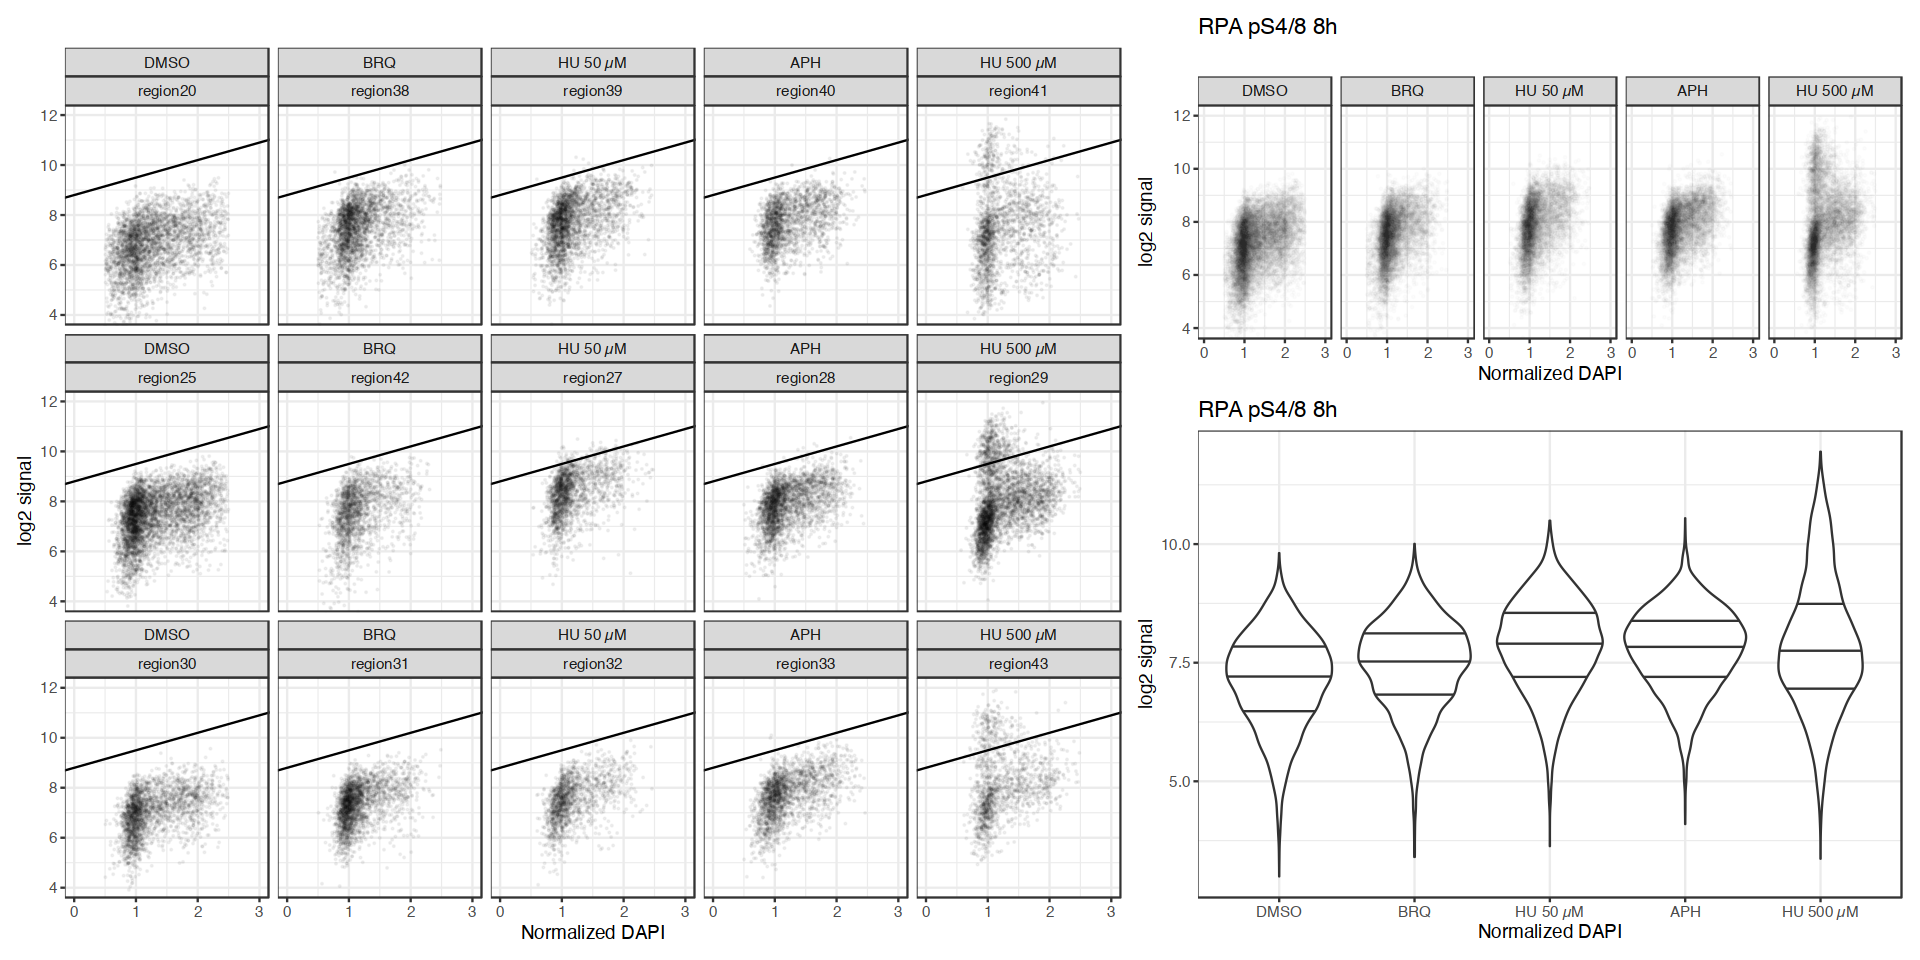

In [14]:
# 8h pRPA S4/8
#dir = "~/Documents/Images/BD432/230907_BD432_8h_pRPAS48_pRPAS33_images/Slide M2 - A2//"
dir = "../data/bd432_data//230907_bd432_8h_prpas48/"

dmso = do.call(rbind, lapply(c("region20", "region25", "region30"), function(x) get_data(dir, x, "DMSO")))
brq = do.call(rbind, lapply(c("region38", "region42", "region31"), function(x) get_data(dir, x, "BRQ")))
hu50 = do.call(rbind, lapply(c("region39", "region27", "region32"), function(x) get_data(dir, x, "HU 50 µM")))
aph = do.call(rbind, lapply(c("region40", "region28", "region33"), function(x) get_data(dir, x, "APH")))
hu500 = do.call(rbind, lapply(c("region41", "region29", "region43"), function(x) get_data(dir, x, "HU 500 µM"))) 
                               
all_data_8h_prpa48 = rbind(dmso, brq, hu50, aph, hu500)
all_data_8h_prpa48$tx = factor(all_data_8h_prpa48$tx, levels=c("DMSO", "BRQ", "HU 50 µM", "APH", "HU 500 µM"))
all_data_8h_prpa48$region = factor(all_data_8h_prpa48$region, 
                                    levels=sapply(c("20","38", "39", "40", "41", "25", "42", "27", "28", "29", "30", "31", "32", "33", "43"), 
                                                  function(x) paste("region", x, sep="")))                          
                               
plot_data(all_data_8h_prpa48, "RPA pS4/8 8h", drawline=T, m=0.7, b=8.8)
#ggsave("230910_bd432_ps48rpa_8h.pdf", width=8, height=6)

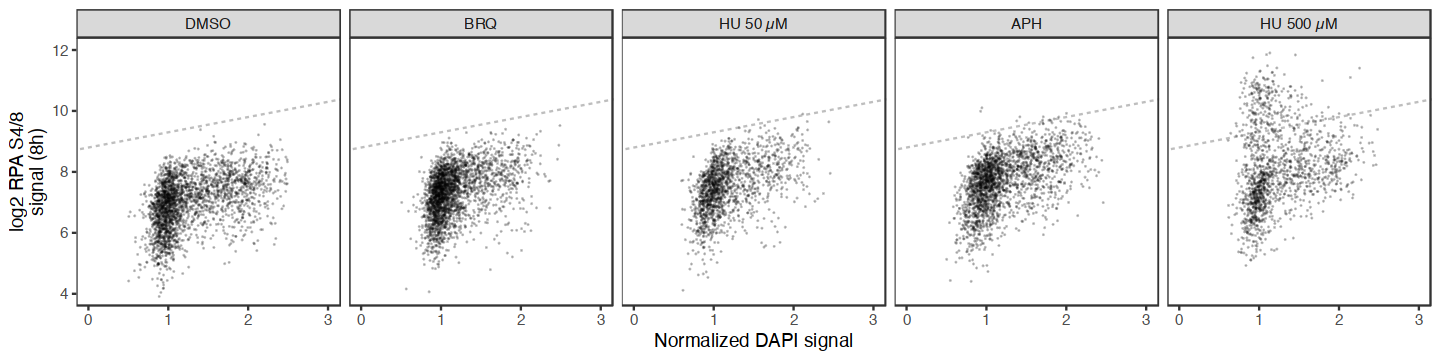

In [15]:
options(repr.plot.width=12, repr.plot.height=3)
g1 = ggplot(subset(all_data_8h_prpa48, region %in% c("region30", "region31", "region32", "region33", "region43")),
            aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_abline(slope=0.5, intercept=8.8, color="gray", linetype=2) + 
rasterise(geom_point(alpha=0.2, size=0.01), dpi=300) + facet_wrap(facets=c("tx"), nrow=1) + theme_bw() + 
coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + xlab("Normalized DAPI signal") + ylab("log2 RPA S4/8\nsignal (8h)") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

g1

ggsave("../output/230912_bd432_8h_rpa48.pdf", width=6, height=1.5)

In [16]:
# 
# m = 0.3, b=8
all_data_8h_prpa48 %>% group_by(region, tx) %>% summarize(pct1 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 8)/n(),
                                                          pct2 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 8.3)/n(),
                                                          pct3 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 7.8)/n(),
                                                          pct4 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.7 * dapi_norm + 8.8)/n(), # high
                                                          mfi = median(Intensity_IntegratedIntensity_OrigRed))  

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx        pct1        pct2        pct3       pct4         mfi     
1  region20 DMSO      0.014277216 0.002676978 0.02706722 0.0000000000 116.8647
2  region38 BRQ       0.091556822 0.036337727 0.15033844 0.0003562522 191.6549
3  region39 HU 50 µM  0.156079855 0.066424682 0.23847550 0.0029038113 220.0824
4  region40 APH       0.117125984 0.037893701 0.19832677 0.0009842520 214.4902
5  region41 HU 500 µM 0.201637666 0.165301945 0.22057318 0.1079836233 165.9314
6  region25 DMSO      0.054031414 0.015497382 0.10429319 0.0000000000 183.4980
7  region42 BRQ       0.135076253 0.057189542 0.20860566 0.0010893246 204.6961
8  region27 HU 50 µM  0.418520435 0.263838593 0.51939990 0.0269011899 343.4784
9  region28 APH       0.157838225 0.057623479 0.26234789 0.0035790981 246.5804
10 region29 HU 500 µM 0.264834318 0.212689443 0.30798870 0.1250963267 229.3490
11 region30 DMSO      0.005338809 0.001232033 0.01437372 0.0000000000 134.8941
12 region31 BRQ       0.025883320 0.005341002 0.05957272 0.0000000000 169.2039
13 region32 HU 50 µM  0.071190951 0.021956088 0.12175649 0.0000000000 188.2431
14 region33 APH       0.099857347 0.038991916 0.17546362 0.0014265335 217.2392
15 region43 HU 500 µM 0.287491361 0.243953006 0.33172080 0.1478921907 243.9020

[1] 27068    10


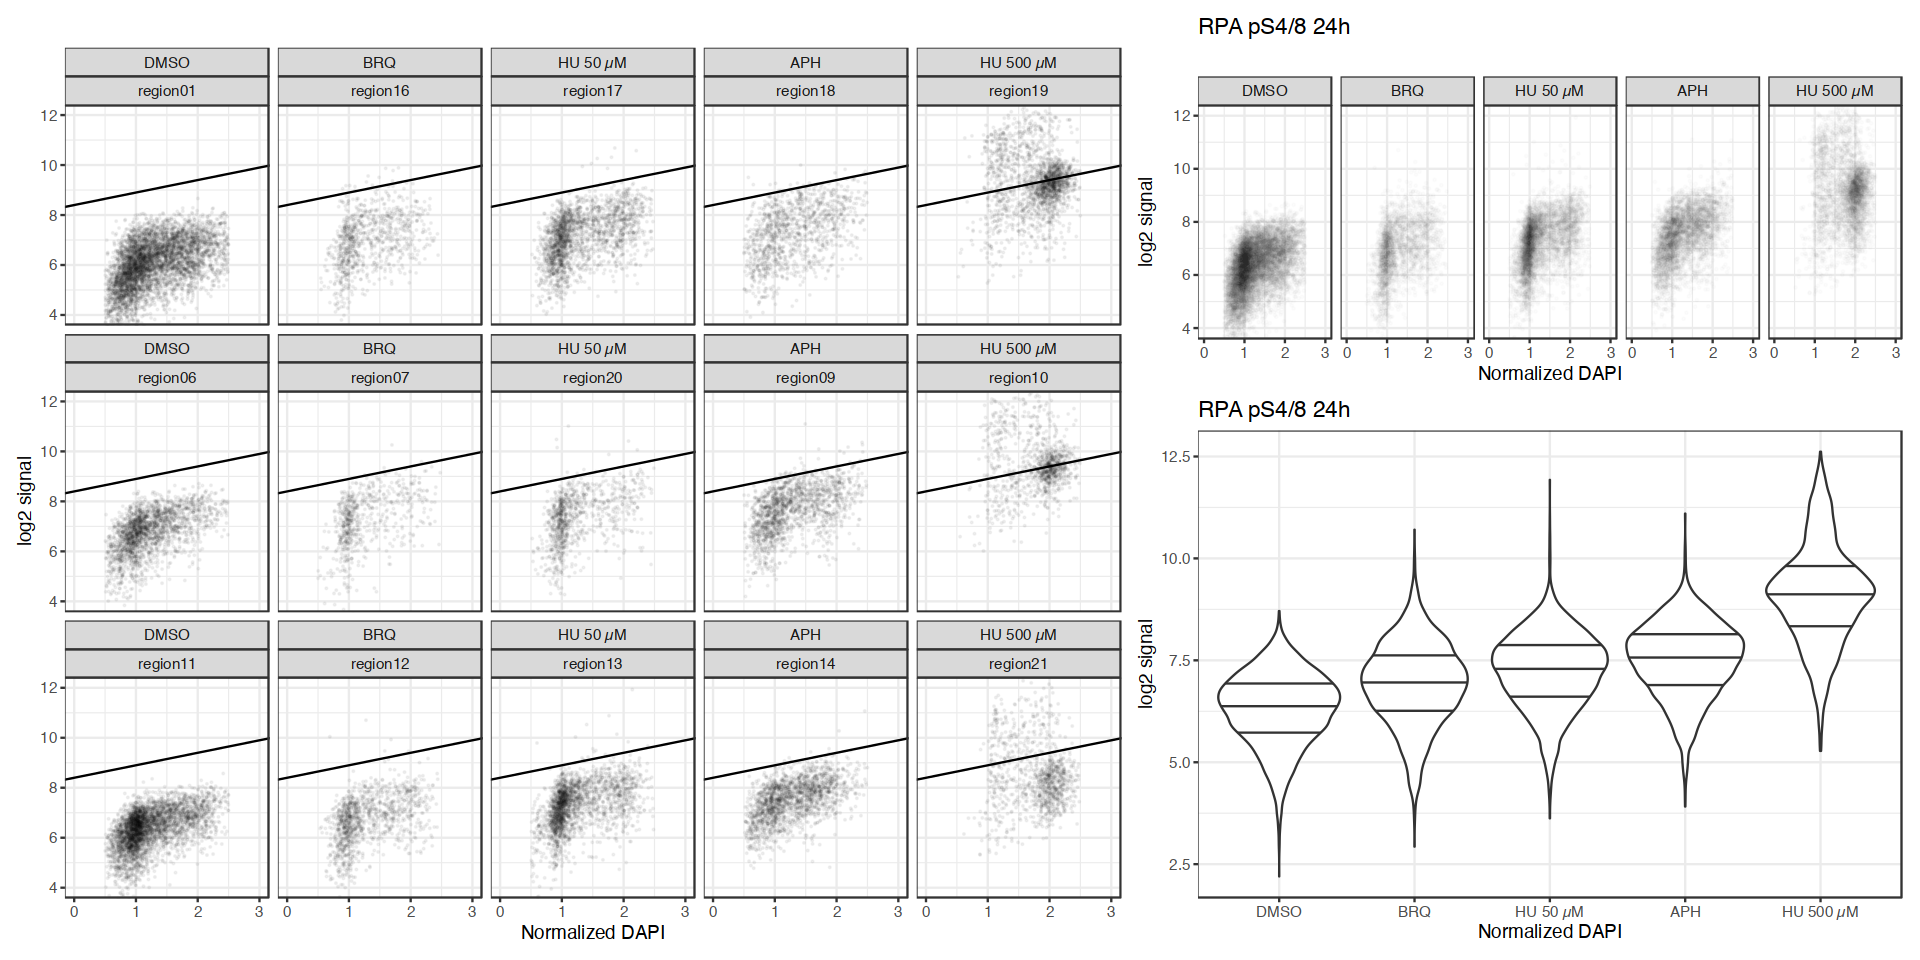

In [17]:
# 24h pRPA S4/8

#dir = "~/Documents/Images/BD432/230907_BD432_24h_pRPAS48_pRPAS33_images/Slide M2 - A3//"
dir = "../data/bd432_data//230907_bd432_24h_prpas48/"

dmso = do.call(rbind, lapply(c("region01", "region06", "region11"), function(x) get_data(dir, x, "DMSO")))
brq = do.call(rbind, lapply(c("region16", "region07", "region12"), function(x) get_data(dir, x, "BRQ")))
hu50 = do.call(rbind, lapply(c("region17", "region20", "region13"), function(x) get_data(dir, x, "HU 50 µM")))
aph = do.call(rbind, lapply(c("region18", "region09", "region14"), function(x) get_data(dir, x, "APH")))
hu500 = do.call(rbind, lapply(c("region19", "region10", "region21"), function(x) get_data(dir, x, "HU 500 µM", g2=TRUE))) 
                               
all_data_24h_prpa48 = rbind(dmso, brq, hu50, aph, hu500)
all_data_24h_prpa48$tx = factor(all_data_24h_prpa48$tx, levels=c("DMSO", "BRQ", "HU 50 µM", "APH", "HU 500 µM"))
all_data_24h_prpa48$region = factor(all_data_24h_prpa48$region, 
                                    levels=sapply(c("01","16", "17", "18", "19", "06", "07", "20", "09", "10", "11", "12", "13", "14", "21"), 
                                                  function(x) paste("region", x, sep="")))
plot_data(all_data_24h_prpa48, "RPA pS4/8 24h", drawline=T, m=0.5, b=8.4)
#ggsave("230910_bd432_ps48rpa_24h.pdf", width=8, height=6)

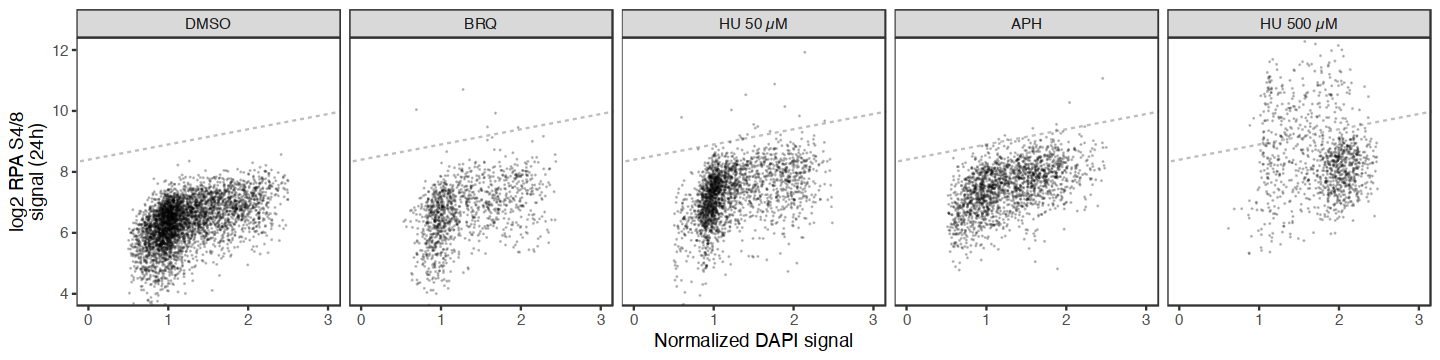

In [18]:
options(repr.plot.width=12, repr.plot.height=3)
g1 = ggplot(subset(all_data_24h_prpa48, region %in% c("region11", "region12", "region13", "region14", "region21")),
            aes(x=dapi_norm, y=log2(Intensity_IntegratedIntensity_OrigRed+1))) + 
geom_abline(slope=0.5, intercept=8.4, color="gray", linetype=2) + 
rasterise(geom_point(alpha=0.2, size=0.01), dpi=300) + facet_wrap(facets=c("tx"), nrow=1) + theme_bw() + 
coord_cartesian(xlim=c(0,3), ylim=c(4,12)) + xlab("Normalized DAPI signal") + ylab("log2 RPA S4/8\nsignal (24h)") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

g1

ggsave("../output/230912_bd432_24h_rpa48.pdf", width=6, height=1.5)

In [19]:
# m = 0.3, b=8
all_data_24h_prpa48 %>% group_by(region, tx) %>% summarize(pct1 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 7.2)/n(),
                                                           pct2 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 7.4)/n(),
                                                           pct3 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 7.0)/n(),
                                                           pct4 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.5 * dapi_norm + 8.4)/n(), # high
                                                           mfi = median(Intensity_IntegratedIntensity_OrigRed))  

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx        pct1        pct2         pct3       pct4        mfi      
1  region01 DMSO      0.005531653 0.0016390084 0.01577546 0.000000000  67.92157
2  region16 BRQ       0.165158371 0.1142533937 0.24660633 0.014705882 130.80393
3  region17 HU 50 µM  0.205722743 0.1386285150 0.30143069 0.004933399 146.81961
4  region18 APH       0.312883436 0.2489044698 0.39614373 0.014899211 168.03922
5  region19 HU 500 µM 0.880151844 0.8470715835 0.90563991 0.455531453 624.23923
6  region06 DMSO      0.046080760 0.0152019002 0.10071259 0.000000000 114.63138
7  region07 BRQ       0.295774648 0.2112676056 0.40219092 0.006259781 157.80785
8  region20 HU 50 µM  0.310722101 0.2231947484 0.41575492 0.010940919 171.74706
9  region09 APH       0.438347321 0.3344092963 0.53001937 0.020012912 209.30197
10 region10 HU 500 µM 0.922254616 0.8979591837 0.94169096 0.493683188 657.36473
11 region11 DMSO      0.002613696 0.0005227392 0.01176163 0.000000000  85.23334
12 region12 BRQ       0.059482759 0.0301724138 0.10862069 0.004310345 108.76275
13 region13 HU 50 µM  0.247702206 0.1585477941 0.34788603 0.007352941 161.13922
14 region14 APH       0.319672131 0.2158469945 0.44590164 0.004371585 187.49608
15 region21 HU 500 µM 0.564440263 0.4807149577 0.63405456 0.217309501 315.56079

[1] 36839    10


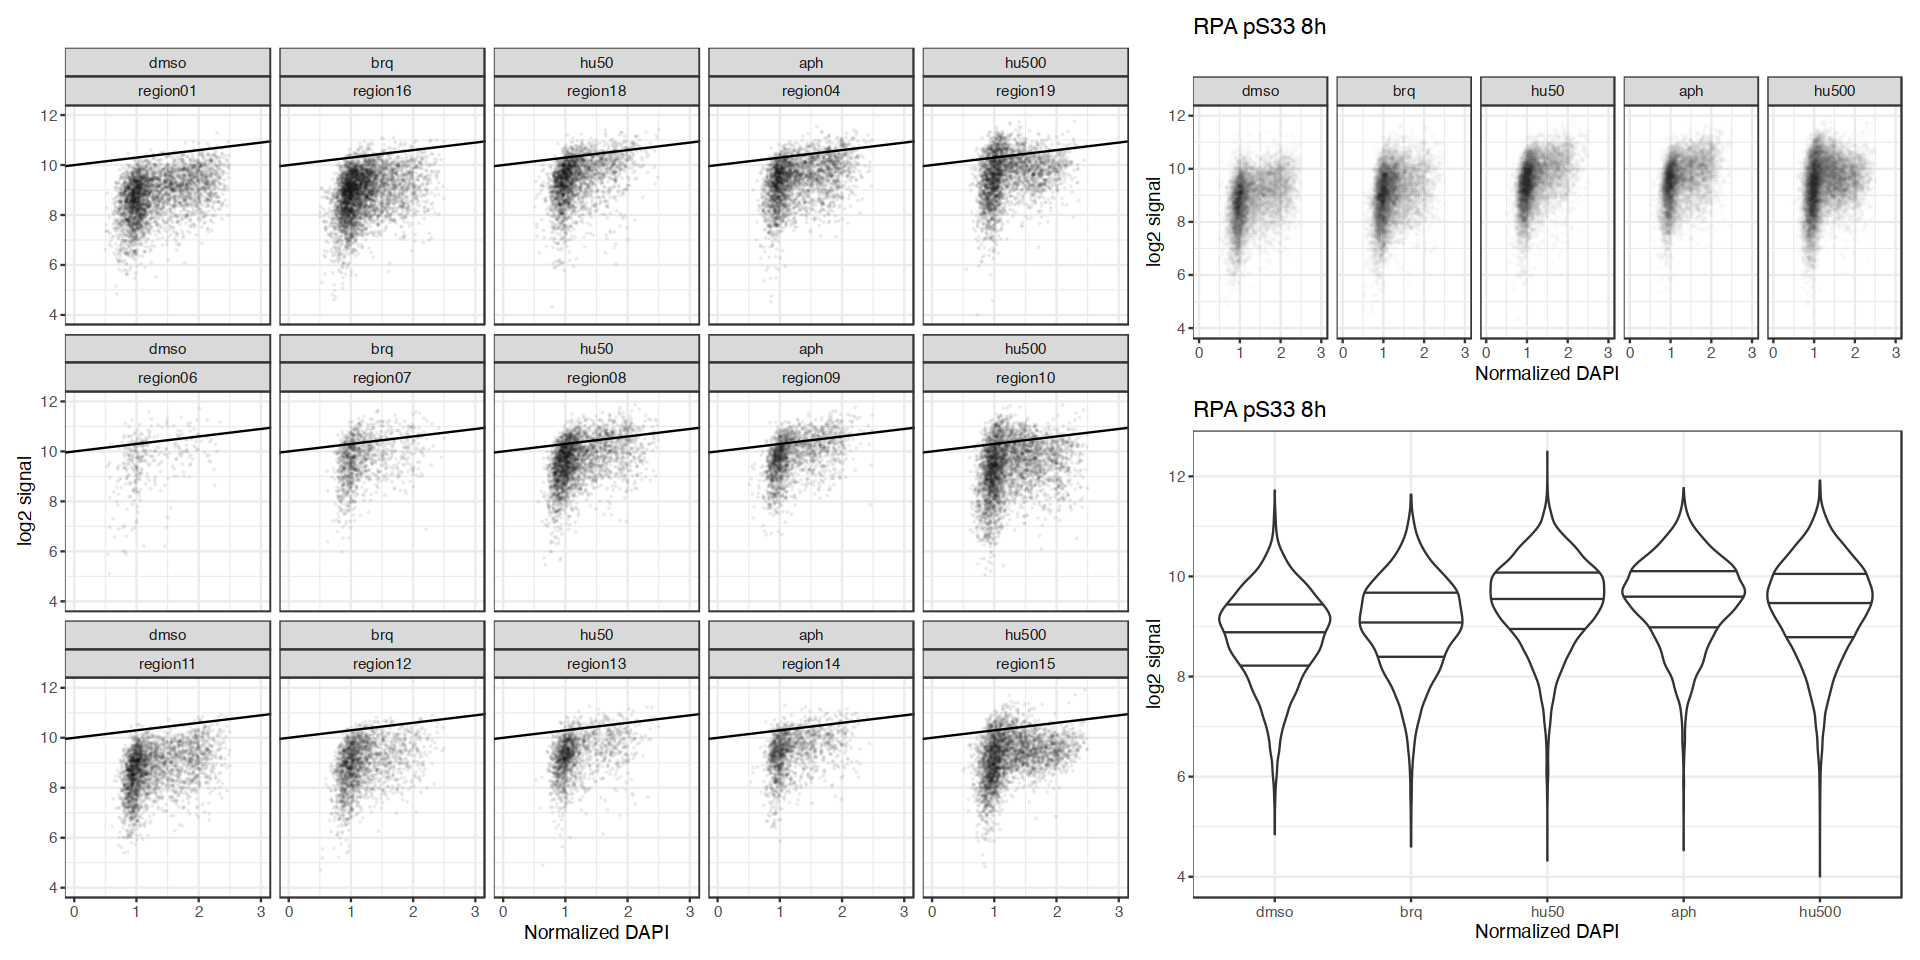

In [20]:
# 8h pRPA S33

#dir = "~/Documents/Images/BD432/230907_BD432_8h_pRPAS48_pRPAS33_images/Slide M2 - B2//"
dir = "../data/bd432_data//230907_bd432_8h_prpas33/"

dmso = do.call(rbind, lapply(c("region01", "region06", "region11"), function(x) get_data(dir, x, "dmso")))
brq = do.call(rbind, lapply(c("region16", "region07", "region12"), function(x) get_data(dir, x, "brq")))
hu50 = do.call(rbind, lapply(c("region18", "region08", "region13"), function(x) get_data(dir, x, "hu50")))
aph = do.call(rbind, lapply(c("region04", "region09", "region14"), function(x) get_data(dir, x, "aph")))
hu500 = do.call(rbind, lapply(c("region19", "region10", "region15"), function(x) get_data(dir, x, "hu500"))) 
                               
all_data_8h_prpa33 = rbind(dmso, brq, hu50, aph, hu500)
all_data_8h_prpa33$tx = factor(all_data_8h_prpa33$tx, levels=c("dmso", "brq", "hu50", "aph", "hu500"))
all_data_8h_prpa33$region = factor(all_data_8h_prpa33$region, 
                                   levels=sapply(c("01","16", "18", "04", "19", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15"), 
                                                 function(x) paste("region", x, sep="")))
plot_data(all_data_8h_prpa33, "RPA pS33 8h", drawline=T, m=0.3, b=10)
#ggsave("230910_bd432_ps33rpa_8h.pdf", width=8, height=6)

In [21]:
# toss out replicate 2 because the DMSO has too few cells 
all_data_8h_prpa33 %>% group_by(region, tx) %>% summarize(pct1 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.3 * dapi_norm + 10)/n(),
                                                          mfi = median(Intensity_IntegratedIntensity_OrigRed))  

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx    pct1        mfi     
1  region01 dmso  0.005328099 467.2882
2  region16 brq   0.019867550 498.0353
3  region18 hu50  0.093662814 742.6079
4  region04 aph   0.079761068 721.3922
5  region19 hu500 0.175315568 825.7647
6  region06 dmso  0.227146814 909.2471
7  region07 brq   0.218132855 872.9863
8  region08 hu50  0.189245088 837.3216
9  region09 aph   0.233795014 944.4196
10 region10 hu500 0.144053601 709.5608
11 region11 dmso  0.006491165 455.4000
12 region12 brq   0.022994379 516.1765
13 region13 hu50  0.060721063 662.5530
14 region14 aph   0.078444748 734.6765
15 region15 hu500 0.073074591 641.0647

[1] 27093    10


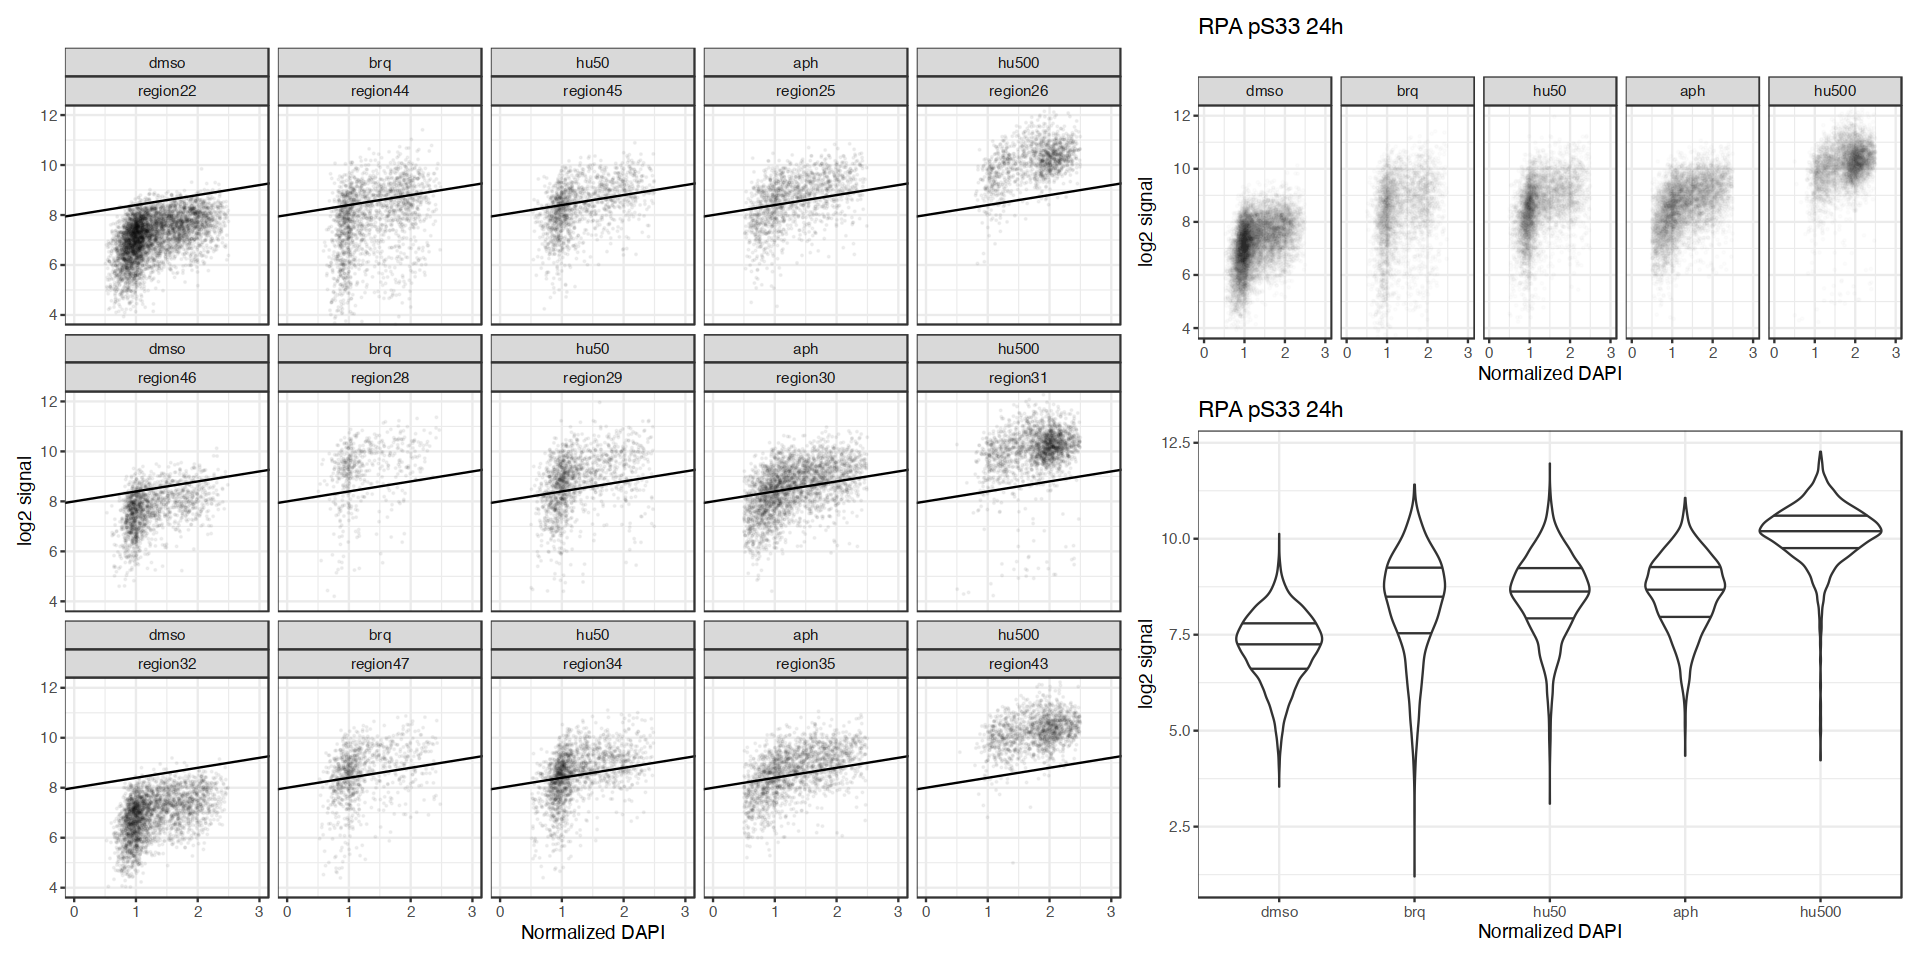

In [22]:
# 24h pRPA S33

#dir = "~/Documents/Images/BD432/230907_BD432_24h_pRPAS48_pRPAS33_images/Slide M2 - B3//"
dir = "../data/bd432_data//230907_bd432_24h_prpas33/"

dmso = do.call(rbind, lapply(c("region22", "region46", "region32"), function(x) get_data(dir, x, "dmso")))
brq = do.call(rbind, lapply(c("region44", "region28", "region47"), function(x) get_data(dir, x, "brq")))
hu50 = do.call(rbind, lapply(c("region45", "region29", "region34"), function(x) get_data(dir, x, "hu50")))
aph = do.call(rbind, lapply(c("region25", "region30", "region35"), function(x) get_data(dir, x, "aph")))
hu500 = do.call(rbind, lapply(c("region26", "region31", "region43"), function(x) get_data(dir, x, "hu500", g2=TRUE))) 
                               
all_data_24h_prpa33 = rbind(dmso, brq, hu50, aph, hu500)
all_data_24h_prpa33$tx = factor(all_data_24h_prpa33$tx, levels=c("dmso", "brq", "hu50", "aph", "hu500"))
all_data_24h_prpa33$region = factor(all_data_24h_prpa33$region, 
                                    levels=sapply(c("22","44", "45", "25", "26", "46", "28", "29", "30", "31", "32", "47", "34", "35", "43"), 
                                                  function(x) paste("region", x, sep="")))
plot_data(all_data_24h_prpa33, "RPA pS33 24h", drawline=T, m=0.4, b=8)
#ggsave("230910_bd432_ps33rpa_24h.pdf", width=8, height=6)

In [23]:
# m = 0.3, b=8
all_data_24h_prpa33 %>% group_by(region, tx) %>% summarize(pct1 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.4 * dapi_norm + 8)/n(),
                                                           pct2 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.4 * dapi_norm + 8.6)/n(),
                                                           pct3 = sum(log2(Intensity_IntegratedIntensity_OrigRed) > 0.4 * dapi_norm + 7.8)/n(),
                                                           mfi = median(Intensity_IntegratedIntensity_OrigRed))  

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region   tx    pct1        pct2         pct3       mfi      
1  region22 dmso  0.015556023 0.0002102165 0.03994114  152.4118
2  region44 brq   0.342668863 0.1455244371 0.42064800  274.8784
3  region45 hu50  0.444850256 0.1782322863 0.55149744  344.3098
4  region25 aph   0.578635015 0.3026706231 0.65207715  427.3549
5  region26 hu500 0.962309543 0.9013632719 0.97914996 1177.8549
6  region46 dmso  0.137254902 0.0164452878 0.20619861  215.8392
7  region28 brq   0.802681992 0.6609195402 0.82758621  689.2667
8  region29 hu50  0.652296820 0.4120141343 0.71872792  477.6981
9  region30 aph   0.539639985 0.2566066641 0.62236691  393.1451
10 region31 hu500 0.956780119 0.8914100486 0.96704484 1142.8040
11 region32 dmso  0.005813953 0.0000000000 0.01417151  127.5431
12 region47 brq   0.602116402 0.3238095238 0.66772487  415.4667
13 region34 hu50  0.559195402 0.2459770115 0.65517241  390.1353
14 region35 aph   0.584788732 0.2946478873 0.67774648  422.6863
15 region43 hu500 0.985283297 0.9352465048 0.98969831 1229.1804